In [1]:
%pip install pandas requests

Note: you may need to restart the kernel to use updated packages.


In [13]:
import time
import requests
import threading
from concurrent.futures import ThreadPoolExecutor

In [14]:
def make_request():
    requests.get("http://127.0.0.1:8000/")


def non_threading():
    # 100 requests sequentially
    for _ in range(100):
        make_request()


def thread_pooling():
    # Thread pool with max 10 worker threads
    with ThreadPoolExecutor(max_workers=10) as executor:
        # Submit 100 tasks to the pool
        for _ in range(100):
            executor.submit(make_request)
    # exiting the `with` block waits for all tasks to complete

One sample testing. not gives much difference between single threading and multithreading. So we will try with big sample size.

In [15]:
print("\n--- Non-threaded run ---")
start = time.perf_counter()
non_threading()
non_threaded_elapsed = time.perf_counter() - start
print(f"\nNon-threaded elapsed: {non_threaded_elapsed:.6f} seconds")

print("\n--- Thread pool run (10 threads, 100 requests) ---")
start = time.perf_counter()
thread_pooling()
threaded_elapsed = time.perf_counter() - start
print(f"\nThread pool elapsed: {threaded_elapsed:.6f} seconds")

if threaded_elapsed < non_threaded_elapsed:
    print(
        "\nThread pooling by {:.6f} seconds".format(
            non_threaded_elapsed - threaded_elapsed
        )
    )
else:
    print(
        "\nNon-threaded by {:.6f} seconds".format(
            threaded_elapsed - non_threaded_elapsed
        )
    )


--- Non-threaded run ---

Non-threaded elapsed: 0.176430 seconds

--- Thread pool run (10 threads, 100 requests) ---

Thread pool elapsed: 0.097216 seconds

Thread pooling by 0.079214 seconds


In [16]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd

In [ ]:
# lets take big sample size now - 
# 100 requests 100 times for (1, 2,5,10,20,50,100) threads and compare the time taken
df = pd.DataFrame(columns=['Threads', 'Avg_Time_Taken_Seconds', 'Successful_Requests', 'Failed_Requests'])
thread_dfs = {}

In [20]:
%pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [21]:
import tqdm

In [24]:
def time_threaded_requests(num_threads, requests_per_run, repeats=100):
    def make_request():
        thread_id = threading.current_thread().ident
        start = time.perf_counter()
        try:
            response = requests.get("http://127.0.0.1:8000/")
            success = response.status_code == 200
        except:  # noqa: E722
            success = False
        elapsed = time.perf_counter() - start
        return elapsed, success, thread_id

    all_results = []
    total_elapsed = 0.0
    total_success = 0
    total_failed = 0
    for _ in tqdm.tqdm(range(repeats)):
        start = time.perf_counter()
        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            futures = [executor.submit(make_request) for _ in range(requests_per_run)]
        results = [future.result() for future in futures]
        elapsed = time.perf_counter() - start
        total_elapsed += elapsed
        for res in results:
            all_results.append(res)
            if res[1]:
                total_success += 1
            else:
                total_failed += 1
    avg_elapsed = total_elapsed / repeats
    return avg_elapsed, total_success, total_failed, all_results

thread_counts = [1, 2, 5, 10, 20, 50, 100]
requests_per_run = 100
repeats = 100
for threads in thread_counts:
    avg_elapsed_time, success, failed, results = time_threaded_requests(threads, requests_per_run, repeats)
    requests_per_second = requests_per_run / avg_elapsed_time
    df1 = pd.DataFrame({
        'Threads': threads,
        'Avg_Time_Taken_Seconds': avg_elapsed_time,
        'Successful_Requests': success,
        'Failed_Requests': failed,
    }, index=[len(df)+1])

    df = pd.concat([df, df1], ignore_index=True)
    thread_dfs[threads] = pd.DataFrame([(r[0], r[2]) for r in results], columns=['Time', 'Thread_ID'])

100%|██████████| 100/100 [00:19<00:00,  5.26it/s]
/var/folders/f9/kj87hz5s6qs191_cyq1ndtd80000gp/T/ipykernel_95030/826531408.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df1], ignore_index=True)
100%|██████████| 100/100 [00:11<00:00,  8.95it/s]


In [26]:
# Display the master dataframe
df

,Threads,Avg_Time_Taken_Seconds,Successful_Requests,Failed_Requests
0,1,0.189431,10000,0
1,2,0.129746,6415,3585
2,5,0.106162,5876,4124
3,10,0.103768,6428,3572
4,20,0.106383,4735,5265
5,50,0.110902,5869,4131
6,100,0.111052,5932,4068


In [28]:
# Display the separate dataframes for each thread count (showing first 5 rows for brevity)
for threads, tdf in thread_dfs.items():
    print(f"\nThread count {threads}:")
    display(tdf.head(50))


Thread count 1:


,Time,Thread_ID
0,0.003006,123145492676608
1,0.002154,123145492676608
2,0.002368,123145492676608
3,0.002947,123145492676608
4,0.002478,123145492676608
5,0.002210,123145492676608
6,0.002400,123145492676608
7,0.002287,123145492676608
8,0.002439,123145492676608
9,0.002946,123145492676608



Thread count 2:


,Time,Thread_ID
0,0.003721,123145492676608
1,0.003441,123145509466112
2,0.002885,123145492676608
3,0.003112,123145509466112
4,0.002839,123145492676608
5,0.002706,123145509466112
6,0.002462,123145492676608
7,0.002837,123145509466112
8,0.003171,123145492676608
9,0.002748,123145509466112



Thread count 5:


,Time,Thread_ID
0,0.007048,123145459097600
1,0.005332,123145492676608
2,0.007123,123145509466112
3,0.006039,123145526255616
4,0.006289,123145543045120
5,0.005612,123145492676608
6,0.005541,123145459097600
7,0.005064,123145509466112
8,0.005538,123145526255616
9,0.003885,123145543045120



Thread count 10:


,Time,Thread_ID
0,0.004910,123145459097600
1,0.004560,123145492676608
2,0.005620,123145509466112
3,0.006467,123145526255616
4,0.009434,123145543045120
5,0.007729,123145459097600
6,0.009980,123145559834624
7,0.012667,123145492676608
8,0.007985,123145576624128
9,0.010150,123145593413632



Thread count 20:


,Time,Thread_ID
0,0.004453,123145459097600
1,0.005537,123145492676608
2,0.006174,123145509466112
3,0.007735,123145526255616
4,0.005412,123145543045120
5,0.008771,123145459097600
6,0.009608,123145559834624
7,0.010916,123145576624128
8,0.008563,123145492676608
9,0.011995,123145593413632



Thread count 50:


,Time,Thread_ID
0,0.004729,123145459097600
1,0.004923,123145492676608
2,0.010518,123145509466112
3,0.007168,123145526255616
4,0.005936,123145543045120
5,0.010077,123145559834624
6,0.006238,123145459097600
7,0.010955,123145576624128
8,0.007996,123145593413632
9,0.013916,123145492676608



Thread count 100:


,Time,Thread_ID
0,0.005514,123145459097600
1,0.004710,123145492676608
2,0.005581,123145509466112
3,0.006759,123145526255616
4,0.007159,123145543045120
5,0.009862,123145559834624
6,0.011198,123145576624128
7,0.008608,123145459097600
8,0.009620,123145492676608
9,0.011302,123145509466112


In [30]:
%pip install matplotlib

  Using cached matplotlib-3.10.8-cp313-cp313-macosx_10_13_x86_64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp313-cp313-macosx_10_13_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-macosx_10_13_x86_64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.8-cp313-cp313-macosx_10_13_x86_64.whl (8.3 MB)
Using cached contourpy-1.3.3-cp313-cp313-macosx_10_13_x86_64.whl (293 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached kiwisolver-1.4.9-cp313-cp313-macosx_10_13_x86_64.whl (66 kB)
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [matplotlib]5 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


<Axes: title={'center': 'Average Time Taken vs Number of Threads'}, xlabel='Threads'>

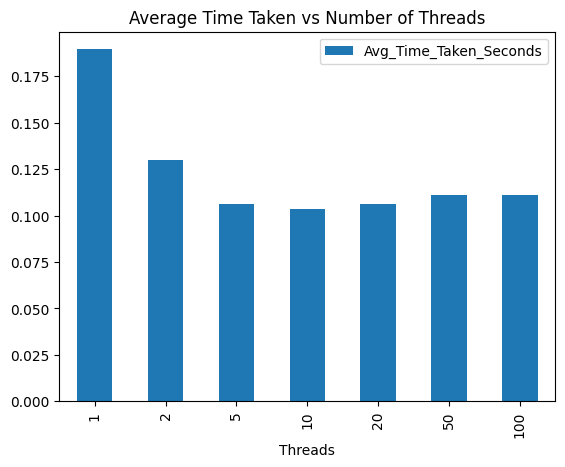

In [31]:
df.plot(x='Threads', y='Avg_Time_Taken_Seconds', kind='bar', title='Average Time Taken vs Number of Threads')

In [37]:
# Plot time distributions for each thread count by showing each line as a own thread in x as requests numbers

for threads, tdf in thread_dfs.items():
    display(tdf.plot(kind='line', x=tdf.index, y='Time', title=f'Time Distribution for {threads} Threads'))

KeyError: 'None of [RangeIndex(start=0, stop=10000, step=1)] are in the [columns]'